# Feature engineering 1

## Set-up

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

In [2]:
os.chdir('..')

In [3]:
from src.models.baseline_model import BaselineModel  # Need to import class for creating baseline model (see explanation in 02-Baseline model)
from src.data.utils import COLUMN_DESCRIPTION_DICT

In [4]:
pd.options.display.max_columns = None

## More explicit null imputation for categorical features

In [5]:
train = pd.read_parquet('data/interim/train.parquet')
print(f"Train size: {train.shape}")
dev = pd.read_parquet('data/interim/dev.parquet')
print(f"Dev size: {dev.shape}")

Train size: (184506, 122)
Dev size: (61502, 122)


In [6]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,297783,0,Cash loans,F,N,Y,0,74250.0,112500.0,6282.0,112500.0,Unaccompanied,Working,Incomplete higher,Married,House / apartment,0.018850,-15077,-7915,-2853.0,-8,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,SATURDAY,10,0,0,0,0,0,0,School,NaN,0.598495,0.728141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,1.0,1.0,0.0,-793.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
1,390572,0,Revolving loans,F,Y,Y,2,225000.0,810000.0,40500.0,810000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-14311,-1858,-2306.0,-5196,4.0,1,1,0,1,0,0,High skill tech staff,4.0,2,2,FRIDAY,13,0,0,0,0,0,0,Business Entity Type 3,0.578538,0.491977,0.200926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,-312.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,212363,0,Cash loans,M,Y,N,0,225000.0,1546020.0,42642.0,1350000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,Municipal apartment,0.032561,-15236,-5751,-7483.0,-4492,8.0,1,1,0,1,1,0,Drivers,2.0,1,1,TUESDAY,16,0,0,0,0,0,0,Business Entity Type 3,0.467365,0.591815,0.762336,0.1103,0.0857,0.9831,0.7688,NaN,0.12,0.1034,0.3333,0.375,NaN,NaN,0.1214,NaN,NaN,0.1124,0.089,0.9831,0.7779,NaN,0.1208,0.1034,0.3333,0.375,NaN,NaN,0.1265,NaN,NaN,0.1114,0.0857,0.9831,0.7719,NaN,0.12,0.1034,0.3333,0.375,NaN,NaN,0.1236,NaN,NaN,reg oper account,block of flats,0.0975,Panel,No,0.0,0.0,0.0,0.0,-1767.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,116368,1

In [7]:
object_columns = train.select_dtypes(include=object).columns

train[object_columns].isnull().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                  787
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                57649
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            126235
HOUSETYPE_MODE                 92655
WALLSMATERIAL_MODE             93890
EMERGENCYSTATE_MODE            87465
dtype: int64

In [8]:
categorical_features_with_nulls = list(train[object_columns].isnull().sum()[train[object_columns].isnull().sum() > 0].index)
categorical_features_with_nulls

['NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [9]:
application_dat_dict = COLUMN_DESCRIPTION_DICT['application_{train|test}.csv']

In [10]:
for feature in categorical_features_with_nulls:
    print('---------------------------------------------')
    print(feature)
    print('\n')
    print(train[feature].value_counts(dropna=False))
    print('\n')
    print(application_dat_dict[feature])
    print('---------------------------------------------')
    print('\n')

---------------------------------------------
NAME_TYPE_SUITE


Unaccompanied      149065
Family              24087
Spouse, partner      6832
Children             1985
Other_B              1046
NaN                   787
Other_A               543
Group of people       161
Name: NAME_TYPE_SUITE, dtype: int64


{'Description': 'Who was accompanying client when he was applying for the loan', 'Special': nan}
---------------------------------------------


---------------------------------------------
OCCUPATION_TYPE


NaN                      57649
Laborers                 33261
Sales staff              19206
Core staff               16561
Managers                 12871
Drivers                  11190
High skill tech staff     6898
Accountants               5875
Medicine staff            5132
Security staff            4049
Cooking staff             3553
Cleaning staff            2823
Private service staff     1544
Low-skill Laborers        1225
Waiters/barmen staff       792
Secretaries     

1) `NAME_TYPE_SUITE`:

Not clear what the difference is between `Other_A` and `Other_B`. Number of nulls is comparable to these so __map all 3 to `Other`__

2) `OCCUPATION_TYPE`:

Are nulls unemployed?

In [11]:
train['NAME_INCOME_TYPE'].value_counts(dropna=False)

Working                 95016
Commercial associate    43136
Pensioner               33235
State servant           13088
Unemployed                 15
Student                    11
Businessman                 4
Maternity leave             1
Name: NAME_INCOME_TYPE, dtype: int64

In [12]:
train[train['OCCUPATION_TYPE'].isnull()]['NAME_INCOME_TYPE'].value_counts(dropna=False)

Pensioner               33232
Working                 14777
Commercial associate     7369
State servant            2253
Unemployed                 15
Student                     3
Name: NAME_INCOME_TYPE, dtype: int64

Null `OCCUPATION_TYPE` aren't all just unemployed but large group are pensioners.

In [13]:
# Do all unemployed have a null occupation type?
train[train['NAME_INCOME_TYPE'] == 'Unemployed']['OCCUPATION_TYPE'].value_counts(dropna=False)

NaN    15
Name: OCCUPATION_TYPE, dtype: int64

Yes, therefore __if `NAME_INCOME_TYPE` = 'Unemployed' set `OCCUPATION_TYPE` to 'Unemployed'__

In [14]:
train[train['NAME_INCOME_TYPE'] == 'Pensioner']['OCCUPATION_TYPE'].value_counts(dropna=False)

NaN               33232
Sales staff           1
Medicine staff        1
Cleaning staff        1
Name: OCCUPATION_TYPE, dtype: int64

__If `NAME_INCOME_TYPE` = 'Pensioner' and `OCCUPATION_TYPE` is null set `OCCUPATION_TYPE` to 'Pensioner'__

In [15]:
train[train['NAME_INCOME_TYPE'] == 'Commercial associate']['OCCUPATION_TYPE'].value_counts(dropna=False)

Laborers                 7703
NaN                      7369
Sales staff              6669
Managers                 5364
Core staff               3967
Drivers                  2927
Accountants              2403
High skill tech staff    2146
Security staff            952
Cooking staff             765
Medicine staff            623
Private service staff     613
Cleaning staff            558
Waiters/barmen staff      223
Low-skill Laborers        207
Realty agents             206
Secretaries               201
HR staff                  128
IT staff                  112
Name: OCCUPATION_TYPE, dtype: int64

Looks like most Commercial associates have an `OCCUPATION_TYPE` of Laborer, therefore if __if `NAME_INCOME_TYPE` = 'Commercial associate' and `OCCUPATION_TYPE` is null set `OCCUPATION_TYPE` to 'Laborers'__

In [16]:
train[train['NAME_INCOME_TYPE'] == 'State servant']['OCCUPATION_TYPE'].value_counts(dropna=False)

Core staff               4150
NaN                      2253
Medicine staff           1590
Managers                 1328
Laborers                 1136
High skill tech staff     619
Drivers                   503
Accountants               429
Cooking staff             284
Security staff            230
Cleaning staff            158
Secretaries               152
Sales staff               112
HR staff                   40
Waiters/barmen staff       33
IT staff                   32
Private service staff      22
Low-skill Laborers         14
Realty agents               3
Name: OCCUPATION_TYPE, dtype: int64

__If `NAME_INCOME_TYPE` = 'State servant' and `OCCUPATION_TYPE` is null set `OCCUPATION_TYPE` to 'Laborers'__ This is not the most common occupation but laborers seems more generic than core staff

In [17]:
train[train['NAME_INCOME_TYPE'] == 'Working']['OCCUPATION_TYPE'].value_counts(dropna=False)

Laborers                 24419
NaN                      14777
Sales staff              12424
Core staff                8442
Drivers                   7759
Managers                  6176
High skill tech staff     4133
Accountants               3042
Medicine staff            2918
Security staff            2867
Cooking staff             2504
Cleaning staff            2106
Low-skill Laborers        1002
Private service staff      909
Waiters/barmen staff       535
Secretaries                434
Realty agents              246
HR staff                   166
IT staff                   157
Name: OCCUPATION_TYPE, dtype: int64

__If `NAME_INCOME_TYPE` = 'Working' and `OCCUPATION_TYPE` is null set `OCCUPATION_TYPE` to 'Laborers'__

In [18]:
train[train['NAME_INCOME_TYPE'] == 'Student']['OCCUPATION_TYPE'].value_counts(dropna=False)

NaN                     3
Low-skill Laborers      2
Laborers                2
Accountants             1
Drivers                 1
Core staff              1
Waiters/barmen staff    1
Name: OCCUPATION_TYPE, dtype: int64

In [19]:
train[
    (train['OCCUPATION_TYPE'].isnull()) &
    (train['NAME_INCOME_TYPE'] == 'Student')
]['AMT_INCOME_TOTAL']

127522    157500.0
180622    112500.0
182342     81000.0
Name: AMT_INCOME_TOTAL, dtype: float64

Non-zero incomes in these cases so let's __also map to Laborers__

3) `FONDKAPREMONT_MODE`

Let's drop this variable as it is not clear what this is and there is a large proportion of nulls in the data. Interestingly looks like this could point to data being from Kazakhstan (https://www.kaggle.com/c/home-credit-default-risk/discussion/62122)

If monetary values are in the local currency then exchange rate differences explain the large values e.g. 157,500 Kazakhstani Tenge (income of one of the students above) is the equivalent of £300!

4) `HOUSETYPE_MODE`

In [20]:
train['HOUSETYPE_MODE'].value_counts(dropna=False) / len(train)

NaN                 0.502179
block of flats      0.489198
specific housing    0.004835
terraced house      0.003788
Name: HOUSETYPE_MODE, dtype: float64

In [21]:
train['NAME_HOUSING_TYPE'].value_counts(dropna=False)

House / apartment      163742
With parents             8950
Municipal apartment      6636
Rented apartment         2924
Office apartment         1562
Co-op apartment           692
Name: NAME_HOUSING_TYPE, dtype: int64

Vast majority are block of flats. __Set anything other than 'block of flats' to 'not block of flats'__. `NAME_HOUSING_TYPE` already provides more granular detail and doesn't have nulls.

5) `WALLSMATERIAL_MODE`

In [22]:
application_dat_dict['WALLSMATERIAL_MODE']

{'Description': 'Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor',
 'Special': 'normalized'}

In [23]:
[x for x in list(application_dat_dict.keys()) if 'MATERIAL' in x]

['WALLSMATERIAL_MODE']

In [24]:
train['WALLSMATERIAL_MODE'].value_counts(dropna=False) / len(train)

NaN             0.508872
Panel           0.214958
Stone, brick    0.209912
Block           0.030205
Wooden          0.017533
Mixed           0.007539
Monolithic      0.005772
Others          0.005209
Name: WALLSMATERIAL_MODE, dtype: float64

In [25]:
for name_housing_type in train['NAME_HOUSING_TYPE'].unique():
    print(name_housing_type)
    print('\n')
    print(train[train['NAME_HOUSING_TYPE'] == name_housing_type]['WALLSMATERIAL_MODE'].value_counts(dropna=False))
    print('\n')

House / apartment


NaN             83276
Panel           35247
Stone, brick    34704
Block            4923
Wooden           2548
Mixed            1253
Monolithic        952
Others            839
Name: WALLSMATERIAL_MODE, dtype: int64


Municipal apartment


NaN             2374
Panel           1812
Stone, brick    1544
Wooden           427
Block            309
Others            71
Mixed             67
Monolithic        32
Name: WALLSMATERIAL_MODE, dtype: int64


With parents


NaN             5135
Panel           1734
Stone, brick    1596
Block            203
Wooden           157
Monolithic        51
Mixed             42
Others            32
Name: WALLSMATERIAL_MODE, dtype: int64


Office apartment


NaN             871
Panel           303
Stone, brick    282
Block            43
Wooden           24
Monolithic       16
Others           13
Mixed            10
Name: WALLSMATERIAL_MODE, dtype: int64


Rented apartment


NaN             1939
Stone, brick     423
Panel            396
Block 

In [26]:
train_copy = train.copy()

In [27]:
train_copy = pd.get_dummies(train_copy, columns=['WALLSMATERIAL_MODE'], dummy_na=True)

In [28]:
corr = train_copy.corr()

In [29]:
corr['TARGET'].tail(10)

AMT_REQ_CREDIT_BUREAU_QRT         -0.002276
AMT_REQ_CREDIT_BUREAU_YEAR         0.019344
WALLSMATERIAL_MODE_Block          -0.008590
WALLSMATERIAL_MODE_Mixed          -0.000926
WALLSMATERIAL_MODE_Monolithic     -0.008353
WALLSMATERIAL_MODE_Others          0.001551
WALLSMATERIAL_MODE_Panel          -0.032148
WALLSMATERIAL_MODE_Stone, brick   -0.012573
WALLSMATERIAL_MODE_Wooden          0.008722
WALLSMATERIAL_MODE_nan             0.038513
Name: TARGET, dtype: float64

Correlation of nulls with target is in different direction to correlation of stone/panel. Rather than imputing, __fill nulls with 'Unknown'__

6) `EMERGENCYSTATE_MODE`

In [30]:
train['EMERGENCYSTATE_MODE'].value_counts(dropna=False)

No     95615
NaN    87465
Yes     1426
Name: EMERGENCYSTATE_MODE, dtype: int64

In [31]:
train_copy = train.copy()
train_copy = pd.get_dummies(train_copy, columns=['EMERGENCYSTATE_MODE'], dummy_na=True)

In [32]:
corr = train_copy.corr()
corr['TARGET'].tail()

AMT_REQ_CREDIT_BUREAU_QRT    -0.002276
AMT_REQ_CREDIT_BUREAU_YEAR    0.019344
EMERGENCYSTATE_MODE_No       -0.041625
EMERGENCYSTATE_MODE_Yes       0.006632
EMERGENCYSTATE_MODE_nan       0.040491
Name: TARGET, dtype: float64

__Fill nulls with 'Unknown'__

Imputations above wrapped into a preprocessing function in `src.data.preprocessing`.

In [33]:
from src.data.preprocessing import impute_null_categorical_features

In [34]:
train = impute_null_categorical_features(train)
dev = impute_null_categorical_features(dev)

# Null numerical features

In [35]:
numeric_columns = set(train.columns) - set(object_columns)

In [36]:
numeric_features_with_nulls = train[numeric_columns].isnull().sum()[train[numeric_columns].isnull().sum() > 0]
numeric_features_with_nulls

LANDAREA_MODE                   109591
YEARS_BEGINEXPLUATATION_MODE     90017
APARTMENTS_MODE                  93766
BASEMENTAREA_MODE               108007
FLOORSMAX_MEDI                   91903
                                 ...  
YEARS_BUILD_MEDI                122814
FLOORSMAX_AVG                    91903
LANDAREA_MEDI                   109591
COMMONAREA_AVG                  128976
ELEVATORS_MEDI                   98449
Length: 61, dtype: int64

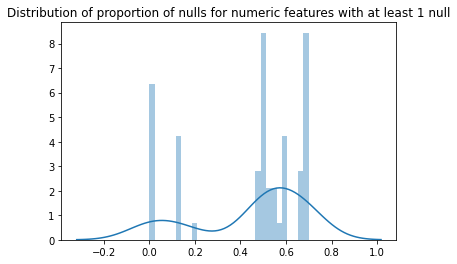

In [37]:
plt.title('Distribution of proportion of nulls for numeric features with at least 1 null')
sns.distplot((numeric_features_with_nulls / len(train)), bins=30)

In [38]:
numeric_features_with_nulls[(numeric_features_with_nulls / len(train)) > 0.5].index

Index(['LANDAREA_MODE', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'LANDAREA_AVG',
       'ENTRANCES_MEDI', 'FLOORSMIN_AVG', 'NONLIVINGAREA_MODE',
       'BASEMENTAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MODE',
       'LIVINGAPARTMENTS_MODE', 'BASEMENTAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'FLOORSMIN_MEDI', 'YEARS_BUILD_AVG', 'LIVINGAREA_AVG',
       'LIVINGAREA_MEDI', 'APARTMENTS_AVG', 'COMMONAREA_MEDI',
       'APARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG',
       'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_AVG', 'ENTRANCES_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'ELEVATORS_MODE', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'EXT_SOURCE_1', 'ENTRANCES_MODE',
       'LIVINGAREA_MODE', 'YEARS_BUILD_MODE', 'OWN_CAR_AGE',
       'YEARS_BUILD_MEDI', 'LANDAREA_MEDI', 'COMMONAREA_AVG',
       'ELEVATORS_MEDI'],
      dtype='object')

### For numeric features with more than 50% nulls how correlated are they with the target?

In [39]:
corr = train.corr()

In [40]:
corr['TARGET'][numeric_features_with_nulls[(numeric_features_with_nulls / len(train)) > 0.5].index].sort_values()

EXT_SOURCE_1               -0.155677
FLOORSMIN_AVG              -0.035304
FLOORSMIN_MEDI             -0.034920
FLOORSMIN_MODE             -0.034413
ELEVATORS_AVG              -0.033733
ELEVATORS_MEDI             -0.033259
LIVINGAREA_AVG             -0.032147
LIVINGAREA_MEDI            -0.032067
ELEVATORS_MODE             -0.031282
LIVINGAREA_MODE            -0.030037
APARTMENTS_AVG             -0.028649
APARTMENTS_MEDI            -0.028396
APARTMENTS_MODE            -0.026588
YEARS_BUILD_MEDI           -0.021915
YEARS_BUILD_AVG            -0.021527
LIVINGAPARTMENTS_AVG       -0.021501
YEARS_BUILD_MODE           -0.021269
LIVINGAPARTMENTS_MEDI      -0.021048
LIVINGAPARTMENTS_MODE      -0.020161
COMMONAREA_AVG             -0.018323
COMMONAREA_MEDI            -0.018208
BASEMENTAREA_AVG           -0.017353
ENTRANCES_AVG              -0.016867
ENTRANCES_MEDI             -0.016541
BASEMENTAREA_MEDI          -0.016465
COMMONAREA_MODE            -0.015696
NONLIVINGAREA_AVG          -0.015268
N

In [41]:
application_dat_dict['EXT_SOURCE_1']

{'Description': 'Normalized score from external data source',
 'Special': 'normalized'}

From experience we know that the external score (usually provided by credit bureaus) can often be very predictive of risk. Should use this if we can rather than dropping completely.

In [42]:
print(train['EXT_SOURCE_1'].isnull().sum() / len(train))
print(train['EXT_SOURCE_2'].isnull().sum() / len(train))
print(train['EXT_SOURCE_3'].isnull().sum() / len(train))

0.5635318092636554
0.0021137523982959904
0.19800982081883517


Text(0.5, 0, 'EXT_SOURCE')

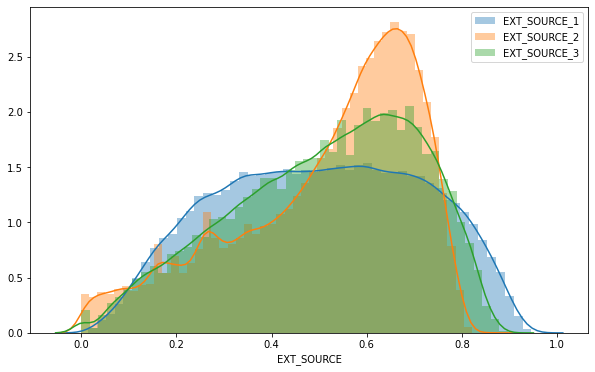

In [43]:
plt.figure(figsize=(10, 6))
sns.distplot(train['EXT_SOURCE_1'], label='EXT_SOURCE_1')
sns.distplot(train['EXT_SOURCE_2'], label='EXT_SOURCE_2')
sns.distplot(train['EXT_SOURCE_3'], label='EXT_SOURCE_3')
plt.legend()
plt.xlabel('EXT_SOURCE')

In [44]:
plot_df = train.copy()[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
plot_df.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,NaN,0.598495,0.728141
1,0.578538,0.491977,0.200926
2,0.467365,0.591815,0.762336
3,NaN,0.077471,NaN
4,0.628605,0.313052,0.715103


In [45]:
plot_df = plot_df.melt().rename(columns={'variable': 'EXT_SOURCE'})
plot_df.head()

,EXT_SOURCE,value
0,EXT_SOURCE_1,NaN
1,EXT_SOURCE_1,0.578538
2,EXT_SOURCE_1,0.467365
3,EXT_SOURCE_1,NaN
4,EXT_SOURCE_1,0.628605


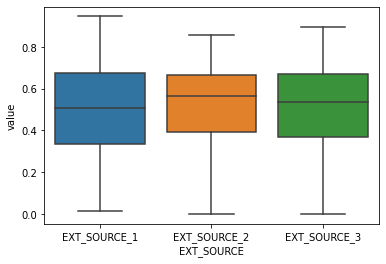

In [46]:
sns.boxplot(x='EXT_SOURCE', y='value', data=plot_df)

In [47]:
train_copy = train.copy()

In [48]:
train_copy['EXT_SOURCE_1_is_null'] = train_copy['EXT_SOURCE_1'].isnull()
train_copy['EXT_SOURCE_2_is_null'] = train_copy['EXT_SOURCE_2'].isnull()
train_copy['EXT_SOURCE_3_is_null'] = train_copy['EXT_SOURCE_3'].isnull()

In [49]:
# When SOURCE_1 is null what proportion of SOURCE_2 and SOURCE_3 are null?
train_copy[train_copy['EXT_SOURCE_1_is_null']].sum()[['EXT_SOURCE_2_is_null', 'EXT_SOURCE_3_is_null']] / \
    train_copy[train_copy['EXT_SOURCE_1_is_null']].count()[['EXT_SOURCE_2_is_null', 'EXT_SOURCE_3_is_null']]

EXT_SOURCE_2_is_null    0.00267372
EXT_SOURCE_3_is_null      0.210695
dtype: object

Relatively few SOURCE_2 nulls when SOURCE_1 is null. Is there a clear relationship between these two which we can model?

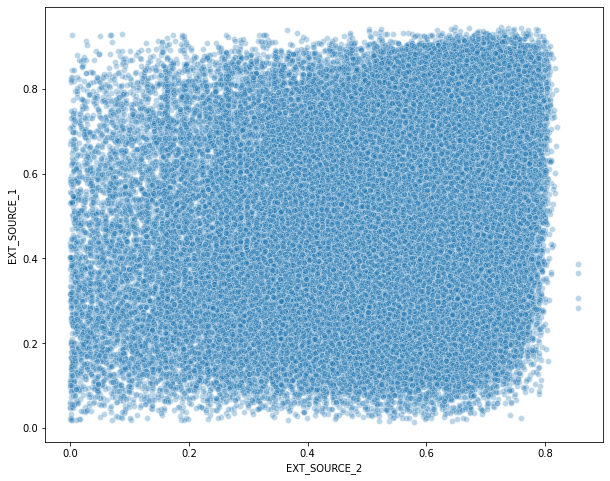

In [53]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=train['EXT_SOURCE_2'], y=train['EXT_SOURCE_1'], alpha=0.3)

In [54]:
max_ext_source_2 = train['EXT_SOURCE_2'].max()
print(max_ext_source_2)
train[train['EXT_SOURCE_2'] == max_ext_source_2]

0.8549996664047012


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
55234,440711,0,Cash loans,M,N,N,0,189000.0,1066320.0,38430.0,900000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.003069,-15752,-2770,-2506.0,-2613,NaN,1,1,0,1,0,0,Core staff,2.0,3,3,THURSDAY,11,0,1,1,1,1,1,Military,0.366075,0.855,0.465069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not block of flats,NaN,Unknown,Unknown,0.0,0.0,0.0,0.0,-473.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
86074,401802,0,Cash loans,M,N,N,0,270000.0,675000.0,21906.0,675000.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.018801,-9636,-674,-4475.0,-2246,NaN,1,1,0,1,0,0,Laborers,1.0,2,2,SUNDAY,8,0,1,1,0,1,1,Police,NaN,0.855,NaN,0.0701,0.0843,0.9811,NaN,NaN,0.0,0.1379,0.1667,NaN,0.0701,NaN,0.0627,NaN,0.0079,0.0714,0.0875,0.9811,NaN,NaN,0.0,0.1379,0.1667,NaN,0.0717,NaN,0.0654,NaN,0.0083,0.0708,0.0843,0.9811,NaN,NaN,0.0,0.1379,0.1667,NaN,0.0713,NaN,0.0639,NaN,0.0080,block of flats,0.0553,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
96861,182029,0,Cash loans,M,N,N,0,90000.0,1078200.0,38331.0,900000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.019101,-13105,-694,-385.0,-3711,NaN,1,1,1,1,1,0,Laborers,2.0,2,2,TUESDAY,9,0,0,0,0,0,0,Self-employed,0.283391,0.855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not block of flats,NaN,Unknown,Unknown,0.0,0.0,0.0,0.0,-303.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
98045,421123,0,Cash loans,F,N,Y,1,283500.0,1093500.0

In [55]:
train['EXT_SOURCE_3'].nunique()

790

In [56]:
len(train)

184506

In [57]:
train['EXT_SOURCE_1'].nunique()

73130

In [58]:
train['EXT_SOURCE_2'].nunique()

94573

In [59]:
train['EXT_SOURCE_3'].head()

0    0.728141
1    0.200926
2    0.762336
3         NaN
4    0.715103
Name: EXT_SOURCE_3, dtype: float64

Given degree of precision of `EXT_SOURCE_3` it seems odd that there are so few distinct values for this feature.

In [60]:
from scipy.stats import pearsonr

In [61]:
pearson_df = train_copy[
    (train_copy['EXT_SOURCE_2_is_null'] == False) & 
    (train_copy['EXT_SOURCE_1_is_null'] == False)
]
pearsonr(pearson_df['EXT_SOURCE_2'], pearson_df['EXT_SOURCE_1'])

(0.21531554232441943, 0.0)

__Is it worth fitting a model to predict EXT_SOURCE_1?__

Build a simple LGBM to see how accurate predictions are

In [62]:
import lightgbm

In [63]:
lgbm_source = lightgbm.LGBMRegressor()

In [64]:
lgbm_data = train_copy[~train_copy['EXT_SOURCE_1'].isnull()]  # Don't want nulls in target
lgbm_data.shape

(80531, 124)

In [65]:
lgbm_source.fit(
    lgbm_data[numeric_columns].drop(
        ['SK_ID_CURR', 'TARGET', 'EXT_SOURCE_1'],
        axis=1
    ), 
    lgbm_data['EXT_SOURCE_1']
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [66]:
preds = lgbm_source.predict(lgbm_data[numeric_columns].drop(['SK_ID_CURR', 'TARGET', 'EXT_SOURCE_1'], axis=1))

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [68]:
mean_squared_error(lgbm_data['EXT_SOURCE_1'], preds)

0.024084659596491798

In [69]:
mean_absolute_error(lgbm_data['EXT_SOURCE_1'], preds)

0.1250137228158165

What if we just predicted the mean for all `EXT_SOURCE_1`?

In [70]:
lgbm_data['EXT_SOURCE_1'].mean()

0.5019220144720008

In [73]:
mean_predictions = np.ones(lgbm_data['EXT_SOURCE_1'].shape[0]) * lgbm_data['EXT_SOURCE_1'].mean()

In [74]:
mean_squared_error(lgbm_data['EXT_SOURCE_1'], mean_predictions)

0.04438202544240746

In [75]:
mean_absolute_error(lgbm_data['EXT_SOURCE_1'], mean_predictions)

0.1788820504552523

Using LGBM with all numerical features has a small improvement over just imputing the mean. Therefore just impute these values for now rather than maintaining a new model. Ideally would like to understand more about this feature and why there are so many nulls.

__Other numerical features with a large number of nulls__

In [77]:
corr['TARGET'][numeric_features_with_nulls[(numeric_features_with_nulls / len(train)) > 0.5].index].sort_values()

EXT_SOURCE_1               -0.155677
FLOORSMIN_AVG              -0.035304
FLOORSMIN_MEDI             -0.034920
FLOORSMIN_MODE             -0.034413
ELEVATORS_AVG              -0.033733
ELEVATORS_MEDI             -0.033259
LIVINGAREA_AVG             -0.032147
LIVINGAREA_MEDI            -0.032067
ELEVATORS_MODE             -0.031282
LIVINGAREA_MODE            -0.030037
APARTMENTS_AVG             -0.028649
APARTMENTS_MEDI            -0.028396
APARTMENTS_MODE            -0.026588
YEARS_BUILD_MEDI           -0.021915
YEARS_BUILD_AVG            -0.021527
LIVINGAPARTMENTS_AVG       -0.021501
YEARS_BUILD_MODE           -0.021269
LIVINGAPARTMENTS_MEDI      -0.021048
LIVINGAPARTMENTS_MODE      -0.020161
COMMONAREA_AVG             -0.018323
COMMONAREA_MEDI            -0.018208
BASEMENTAREA_AVG           -0.017353
ENTRANCES_AVG              -0.016867
ENTRANCES_MEDI             -0.016541
BASEMENTAREA_MEDI          -0.016465
COMMONAREA_MODE            -0.015696
NONLIVINGAREA_AVG          -0.015268
N

In [87]:
(numeric_features_with_nulls / len(train)).sort_values(ascending=False)

COMMONAREA_MEDI             0.699034
COMMONAREA_MODE             0.699034
COMMONAREA_AVG              0.699034
NONLIVINGAPARTMENTS_AVG     0.694752
NONLIVINGAPARTMENTS_MODE    0.694752
                              ...   
EXT_SOURCE_2                0.002114
AMT_GOODS_PRICE             0.000905
AMT_ANNUITY                 0.000043
CNT_FAM_MEMBERS             0.000005
DAYS_LAST_PHONE_CHANGE      0.000005
Length: 61, dtype: float64

Given that largest proportion of nulls is 70% let's adopt the strategy of imputing all values with mean for now. Keep a record of the features which had more than 50% nulls and if these turn out to be very predictive we can investigate further later.

In [90]:
numeric_features_with_greater_than_50pc_nulls = numeric_features_with_nulls[(numeric_features_with_nulls / len(train)) > 0.5].index
numeric_features_with_greater_than_50pc_nulls

Index(['LANDAREA_MODE', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'LANDAREA_AVG',
       'ENTRANCES_MEDI', 'FLOORSMIN_AVG', 'NONLIVINGAREA_MODE',
       'BASEMENTAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MODE',
       'LIVINGAPARTMENTS_MODE', 'BASEMENTAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'FLOORSMIN_MEDI', 'YEARS_BUILD_AVG', 'LIVINGAREA_AVG',
       'LIVINGAREA_MEDI', 'APARTMENTS_AVG', 'COMMONAREA_MEDI',
       'APARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG',
       'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_AVG', 'ENTRANCES_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'ELEVATORS_MODE', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'EXT_SOURCE_1', 'ENTRANCES_MODE',
       'LIVINGAREA_MODE', 'YEARS_BUILD_MODE', 'OWN_CAR_AGE',
       'YEARS_BUILD_MEDI', 'LANDAREA_MEDI', 'COMMONAREA_AVG',
       'ELEVATORS_MEDI'],
      dtype='object')

## Put all preprocessing steps together and fit LGBM

Start fresh

In [5]:
train = pd.read_parquet('data/interim/train.parquet')
print(f"Train size: {train.shape}")
dev = pd.read_parquet('data/interim/dev.parquet')
print(f"Dev size: {dev.shape}")
test = pd.read_parquet('data/interim/test_for_submission.parquet')
print(f"Test size: {test.shape}")

Train size: (184506, 122)
Dev size: (61502, 122)
Test size: (48744, 121)


In [6]:
# object_columns = train.select_dtypes(include=object).columns
# numeric_columns = set(train.columns) - set(object_columns)

In [7]:
from src.data.preprocessing import preprocess_application_data

In [8]:
train['is_train'] = 1
dev['is_dev'] = 1
test['is_test'] = 1
combined = train.append(dev).append(test)
combined.shape

(294752, 125)

In [9]:
combined.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_train,is_dev,is_test
0,297783,0.0,Cash loans,F,N,Y,0,74250.0,112500.0,6282.0,112500.0,Unaccompanied,Working,Incomplete higher,Married,House / apartment,0.018850,-15077,-7915,-2853.0,-8,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,SATURDAY,10,0,0,0,0,0,0,School,NaN,0.598495,0.728141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,1.0,1.0,0.0,-793.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,NaN,NaN
1,390572,0.0,Revolving loans,F,Y,Y,2,225000.0,810000.0,40500.0,810000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-14311,-1858,-2306.0,-5196,4.0,1,1,0,1,0,0,High skill tech staff,4.0,2,2,FRIDAY,13,0,0,0,0,0,0,Business Entity Type 3,0.578538,0.491977,0.200926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,-312.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
2,212363,0.0,Cash loans,M,Y,N,0,225000.0,1546020.0,42642.0,1350000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,Municipal apartment,0.032561,-15236,-5751,-7483.0,-4492,8.0,1,1,0,1,1,0,Drivers,2.0,1,1,TUESDAY,16,0,0,0,0,0,0,Business Entity Type 3,0.467365,0.591815,0.762336,0.1103,0.0857,0.9831,0.7688,NaN,0.12,0.1034,0.3333,0.375,NaN,NaN,0.1214,NaN,NaN,0.1124,0.089,0.9831,0.7779,NaN,0.1208,0.1034,0.3333,0.375,NaN,NaN,0.1265,NaN,NaN,0.1114,0.0857,0.9831,0.7719,NaN,0.12,0.1034,0.3333,0.375,NaN,NaN,0.1236,NaN,NaN,reg oper account,block of flats,0.0975,Panel,No,0.0,0.0,0.0,0.0,-1767.0,0,0,0,0,0,0,1,0,0,0,

### Need to do OHE on _entire_ dataset including test otherwise leads to inevitable errors when a value is in test but not in training or dev sets

In [10]:
combined_processed = preprocess_application_data(combined)

In [11]:
X_train = combined_processed[combined_processed['is_train'] == 1].drop(['SK_ID_CURR', 'TARGET', 'is_train', 'is_dev', 'is_test'], axis=1)
y_train = combined_processed[combined_processed['is_train'] == 1]['TARGET']

X_dev = combined_processed[combined_processed['is_dev'] == 1].drop(['SK_ID_CURR', 'TARGET', 'is_train', 'is_dev', 'is_test'], axis=1)
y_dev = combined_processed[combined_processed['is_dev'] == 1]['TARGET']

print(X_train.shape, y_train.shape, X_dev.shape, y_dev.shape)

(184506, 242) (184506,) (61502, 242) (61502,)


In [12]:
X_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Pensioner,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unemployed,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE

In [13]:
X_train_df = X_train.copy()  # To get column names for later

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [15]:
import lightgbm

In [16]:
full_pipeline = Pipeline(
    [
        (
            'process_data',
            ColumnTransformer(
                [
                    (
                        'processing_steps',
                        Pipeline([
                            ('mean_imputer', SimpleImputer(strategy='mean')),
                            ('min_max_scalar', MinMaxScaler())
                        ]), 
                        make_column_selector(dtype_include=np.number)
                    )
                ]
            )
        ),
        (
            'model', lightgbm.LGBMClassifier()
        )
    ]
)

In [17]:
full_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('process_data',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('processing_steps',
                                                  Pipeline(memory=None,
                                                           steps=[('mean_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                             

In [18]:
training_predictions = full_pipeline.predict_proba(X_train)[:,1]

In [19]:
from sklearn.metrics import roc_auc_score

In [20]:
roc_auc_score(y_train, training_predictions)

0.8100806077822179

Note: 0.8028348943854875 for original baseline model

Dev set ROCAUC

In [21]:
dev_predictions = full_pipeline.predict_proba(X_dev)[:,1]

In [22]:
roc_auc_score(y_dev, dev_predictions)

0.7484771022570353

Note: 0.7446343122063395 for original baseline model

## Submit predictions

In [23]:
X_test = combined_processed[combined_processed['is_test'] == 1].drop(['SK_ID_CURR', 'TARGET', 'is_train', 'is_dev', 'is_test'], axis=1)
X_test.shape

(48744, 242)

In [24]:
test_predictions = full_pipeline.predict_proba(X_test)[:, 1]

In [25]:
test_predictions

array([0.04492687, 0.10400413, 0.02327619, ..., 0.0397842 , 0.05545371,
       0.18784584])

In [26]:
X_test['TARGET'] = test_predictions
X_test['SK_ID_CURR'] = test['SK_ID_CURR']

In [27]:
X_test[['SK_ID_CURR', 'TARGET']].to_csv('data/processed/lgbm_fe1_pipeline_big_fix_submission.csv', index=False)

In [28]:
!kaggle competitions submit -c home-credit-default-risk -f data/processed/lgbm_fe1_pipeline_big_fix_submission.csv -m "LGBM with feature engineering 1 pipeline after bug fix"

100%|███████████████████████████████████████| 1.26M/1.26M [00:07<00:00, 168kB/s]
Successfully submitted to Home Credit Default Risk

### Summary

Private score: 0.73873

Public score: 0.74134

An improvement in both leaderboards compared to baseline model!

## SHAP plot

In [29]:
import shap

In [30]:
process_data = full_pipeline.named_steps['process_data']
model = full_pipeline.named_steps['model']

In [31]:
X_train_processed = process_data.transform(X_train)

In [32]:
X_train_processed.shape

(184506, 242)

In [35]:
input_df = pd.DataFrame(X_train_processed, columns=X_train_df.columns)

In [36]:
model.predict_proba(input_df)

array([[0.96549349, 0.03450651],
       [0.94906295, 0.05093705],
       [0.98232732, 0.01767268],
       ...,
       [0.97358097, 0.02641903],
       [0.88638662, 0.11361338],
       [0.88680997, 0.11319003]])

In [38]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(input_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [45]:
shap_values

[array([[-4.24947932e-04, -5.34014267e-03,  3.68263830e-01, ...,
         -1.07984721e-04,  0.00000000e+00,  1.26353673e-03],
        [ 1.04693503e-03,  1.13218347e-02,  3.16217448e-02, ...,
         -1.23449357e-04,  0.00000000e+00,  1.03962773e-04],
        [-1.32470945e-04,  3.11852199e-02, -1.21674186e-01, ...,
          1.49671550e-04,  0.00000000e+00,  8.25426025e-05],
        ...,
        [-2.07423083e-04,  1.25457034e-02,  2.02961646e-02, ...,
         -1.23589055e-04,  0.00000000e+00,  9.19228279e-05],
        [ 6.94105388e-04,  4.60821177e-02,  3.20637859e-02, ...,
         -1.25838901e-04,  0.00000000e+00,  1.06020698e-04],
        [-7.42661130e-05,  6.99238973e-03, -1.18894654e-01, ...,
          2.04983954e-04,  0.00000000e+00,  1.18306294e-04]]),
 array([[ 4.24947932e-04,  5.34014267e-03, -3.68263830e-01, ...,
          1.07984721e-04,  0.00000000e+00, -1.26353673e-03],
        [-1.04693503e-03, -1.13218347e-02, -3.16217448e-02, ...,
          1.23449357e-04,  0.00000000e+00, -1.03962773e-04],
        [ 1.32470945e-04, -3.11852199e-02,  1.21674186e-01, ...,
         -1.49671550e-04,  0.00000000e+00, -8.25426025e-05],
        ...,
        [ 2.07423083e-04, -1.25457034e-02, -2.02961646e-02, ...,
          1.23589055e-04,  0.00000000e+00, -9.19228279e-05],
        [-6.94105388e-04, -4.60821177e-02, -3.20637859e-02, ...,
          1.25838901e-04,  0.00000000e+00, -1.06020698e-04],
        [ 7.42661130e-05, -6.99238973e-03,  1.18894654e-01, ...,
         -2.04983954e-04,  0.00000000e+00, -1.18306294e-04]])]

Now need to selected shap values corresponding to second array i.e. shap values for probability predictions

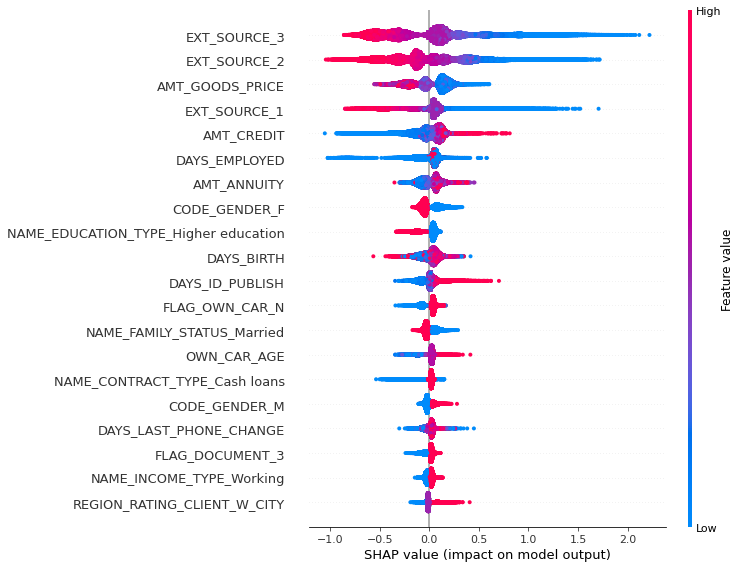

In [46]:
shap.summary_plot(shap_values[1], input_df)

## Key takeaways

- OHE encode on the entire dataset (train/dev/test) to prevent errors when making test predictions). Otherwise carefully map features so they can only be a distinct set of values and anything not seen in training is mapped to 'foo' by default.

- Model did slightly better after adding in all application features and making imputations.

- What if we don't do any imputations at all - LightGBM can deal with nulls